# Nearest neighbor/retrieval ranking visualization

In [1]:
import sys
from netdissect import renormalize, show
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from models.resnet import InsResNet50
from models.LinearModel import LinearClassifierResNet
import os
from torchvision import datasets
from dataset import ImageFolderInstance
from quickdataset import QuickImageFolder
import random

## Choose Imagenet or Places

In [2]:
dataset = "imagenet"
epoch = 240

In [6]:
folder_path = "/data/vision/torralba/ganprojects/yyou/CMC/{}_models".format(dataset)
model_name = "/{}_MoCo0.999_softmax_16384_resnet50_lr_0.03_decay_0.0001_bsz_128_crop_0.2_aug_CJ".format(dataset)
epoch_name = "/ckpt_epoch_{}.pth".format(epoch)
my_path = folder_path + model_name + epoch_name
if dataset == "imagenet":
    data_path =  "/data/vision/torralba/datasets/imagenet_pytorch/imagenet_pytorch"
else:
    data_path = "/data/vision/torralba/datasets/places/places365_standard/places365standard_easyformat"
train_folder = data_path + "/train"
val_folder = data_path + "/val"

In [7]:
crop = 0.2
batch_size = 30
num_workers = 24
train_sampler = None
moco = True
gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)

In [8]:
val_dataset = QuickImageFolder(train_folder)#, transform=val_transform, two_crop=moco)

Making fast dataset ...  /data/vision/torralba/datasets/imagenet_pytorch/imagenet_pytorch/train
Walking image files ... 


In [9]:
len(val_dataset)

1281167

## Load Validation Images

In [5]:
batch_size = 30
num_workers = 24
image_size = 224
crop_padding = 32

val_transform = transforms.Compose([
                    transforms.Resize(image_size + crop_padding),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    normalize,
                ])

val_dataset = QuickImageFolder(val_folder, transform=val_transform, two_crop=moco)

Making fast dataset ...  /data/vision/torralba/datasets/places/places365_standard/places365standard_easyformat/val
Walking image files ... 
from index file:  /data/vision/torralba/datasets/places/places365_standard/places365standard_easyformat/val.txt


In [6]:
val_loader = torch.utils.data.DataLoader(
                val_dataset, batch_size=batch_size, 
                shuffle=False, num_workers=num_workers, pin_memory=True)

## Load the latest model from the checkpoint

In [9]:
model = InsResNet50()
model_ema = InsResNet50()
print("Loading model from ... ", my_path)
checkpoint = torch.load(my_path)
model.load_state_dict(checkpoint['model'])
model_ema.load_state_dict(checkpoint['model_ema'])
model.cuda()
model_ema.cuda()

Loading model from ...  /data/vision/torralba/ganprojects/yyou/CMC/imagenet100_models/imagenet100_MoCo0.999_softmax_16384_resnet50_lr_0.03_decay_0.0001_bsz_128_crop_0.2_aug_CJ/ckpt_epoch_240.pth


InsResNet50(
  (encoder): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

## Create Feature Dictionary or Load Feature Dictionary
### Create feature dictionary
Create feature dictionary by calling ``python image_to_feature.py --epochs 240 --dataset imagenet100``

### Load feature dictionary

In [14]:
import pickle
from PIL import Image

def load_obj(name ):
    print("==> Loading file ... {}".format(name))
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

dataset = "imagenet"
pickle_path = "/data/vision/torralba/ganprojects/yyou/CMC/pkl"
path_to_feat = pickle_path + "/{}_val_to_feat_epch{}".format(dataset, epoch)
path_to_label = pickle_path + "/{}_val_to_label_epch{}".format(dataset, epoch)

dval_feat = load_obj(path_to_feat)
dval_label = load_obj(path_to_label)

==> Loading file ... /data/vision/torralba/ganprojects/yyou/CMC/pkl/imagenet_val_to_feat_epch160


FileNotFoundError: [Errno 2] No such file or directory: '/data/vision/torralba/ganprojects/yyou/CMC/pkl/imagenet_val_to_feat_epch160.pkl'

In [11]:
print(len(dval_feat))

50000


## Helper Functions

In [5]:
def imsave(imlist, fname, source='imagenet', blocks=5):
    """
    Save the list of images(pixel tensors) to the inputted filename
    """
    if len(imlist)==1:
        renormalize.as_image(imlist[0], source=source).save(fname, format='png')
    else:
        im1 = renormalize.as_image(imlist[0], source=source)
        w, h = im1.width, im1.height
        num_vert = len(imlist) // blocks + 1
        dst = Image.new('RGB', (w*blocks, h*num_vert))
        for i, img in enumerate(imlist):
            dst.paste(renormalize.as_image(img, source=source),\
                      ((i%blocks)*w, (i//blocks)*h))
        dst.save(fname, format='png')

def split_img(img):
    x1, x2 = torch.split(img, [3, 3], dim=0)
    return x1

def show_idx(idxlist, source='imagenet'):
    """
    Show images corresponding to the inputted index list
    """
    if len(idxlist)==1:
        print("image", idxlist[0])
        show(renormalize.as_image(split_img(val_dataset[idxlist[0]][0]), source=source))
    else:
        print("idx list", idxlist)
        show([[renormalize.as_image(split_img(val_dataset[idx][0]), source=source)] for idx in idxlist])

In [6]:
def get_nearest_neighbor_idx(query_idx, feature_dict, n=100):
    """ Get the index of n nearest neighbors to query 
    according to the feature dictionary
    The first image is the query image """
    neighbors = {}
    q_feat = feature_dict[query_idx]
    for idx, feat in feature_dict.items():
        neighbors[idx] = np.dot(feat, q_feat)
    neighbors = sorted(neighbors.items(), key=lambda x:x[1], reverse=True)
    return neighbors[:n]
  
def distance_distribution_for_id(query, feature_dict, dataset):
    """ Get the distance histogram for 10,20,50,and 100 nearest
    images for a given inputted query """
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    axs = axs.flatten()
    
    for i, n in enumerate([10,20,50,100]):
        neighbors = get_nearest_neighbor_idx(query, feature_dict, n=n)
        distances = [dist for i,dist in neighbors if i!=query]
        axs[i].hist(distances, bins=15)
        axs[i].set_title('nearest {}'.format(n))
    fig.suptitle("q_idx {}".format(query))
    
def quick_all_distance_distribution(feature_dict, dataset):
    """ Get an analysis of general distances distributions.
    
    For 100 randomly sampled queries, we get the distance for
    20, 100, 500, and all nearest neighbors and create a histogram 
    out if it.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    axs = axs.flatten()
    dist20, dist100, dist500, distAll = [],[],[],[]
    
    for i in range(100):
        query = random.randint(0,len(val_dataset)-1)
        neighbors = get_nearest_neighbor_idx(query, feature_dict, n=len(feature_dict))
        neighbors = [dist for i,dist in neighbors if i!=query]
        dist20.extend(neighbors[:20])
        dist100.extend(neighbors[:100])
        dist500.extend(neighbors[:500])
        distAll.extend(neighbors)
        
    dists = [dist20, dist100, dist500, distAll]
    for i, n in enumerate([20, 100, 500, len(feature_dict)]):
        axs[i].hist(dists[i], bins=25)
        axs[i].set_title('nearest {}'.format(n))
    fig.suptitle("all")

In [7]:
def indices_with_extreme_neighbors(feature_dict, dataset, f=lambda x:x<0.45, n=10, howmany=5):
    """
    We return `howmany` number of query indices such that
    the average distance of `n` nearest neighbors satisfy
    the function `f`
    """
    indices = []
    neighbor_list = []
    distance_list = []
    while True:
        query = random.randint(0,len(val_dataset)-1)
        neighbors = get_nearest_neighbor_idx(query, feature_dict, n=n)
        distances = np.array([dist for i,dist in neighbors if i!=query])
        avg = np.mean(distances)
        if f(avg):
            indices.append(query)
            neighbor_list.append(np.array([i for i,dist in neighbors if i!=query]))
            distance_list.append(distances)
        if len(indices) == howmany:
            return indices, neighbor_list, distance_list

## Most "similar" images within the validation set

In [15]:
wednesday_path = "/data/vision/torralba/scratch/yyou/wednesday/nearest_neighbors"

In [22]:
import random

n=50
for i in range(10):
    q_idx = random.randint(0,len(val_dataset)-1)
    nearest_idx = get_nearest_neighbor_idx(q_idx, dval_feat, n=n)
    nearest_img = [split_img(val_dataset[idx][0]) for idx,score in nearest_idx]
    imsave(nearest_img, wednesday_path+"/epoch{}_query{}_neighbors_{}".format(epoch, q_idx, n))

## What are the distribution of differences like?

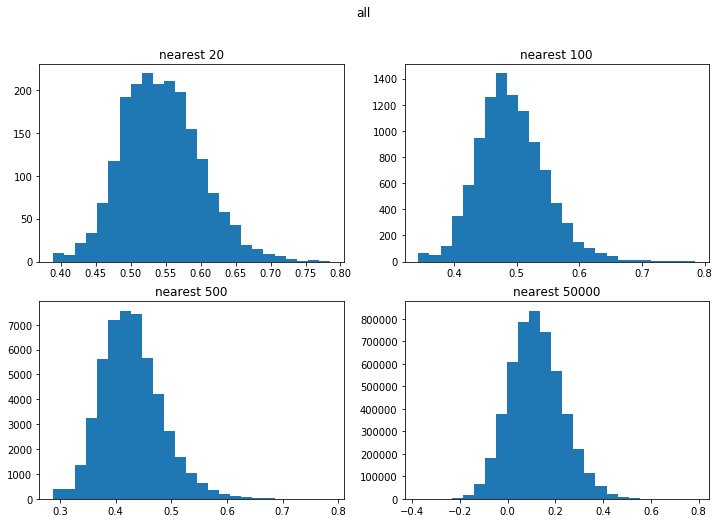

In [23]:
quick_all_distance_distribution(dval_feat, val_dataset)

## What are the images that have most similar images?

### Many neighbors with high similarity

In [54]:
indices, neighbor, dist = indices_with_extreme_neighbors(dval_feat, val_dataset, f=lambda x:x>0.7, n=12, howmany=1)

average dot prod amongst 12 neighbors is :  0.74869543
[0.831826   0.79823273 0.7943101  0.7817048  0.75690883 0.73289526
 0.7304275  0.71967673 0.71528083 0.6892898  0.6850973 ]
idx list [20204, 20230, 45447, 20249, 20235, 20223, 20227, 20239, 44795, 20221, 44761, 44784]



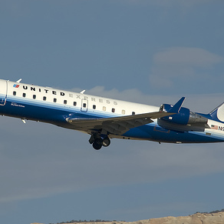
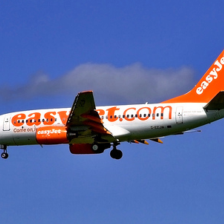
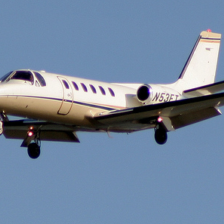
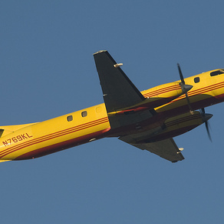
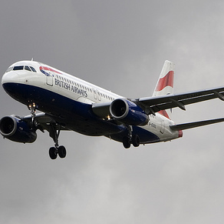
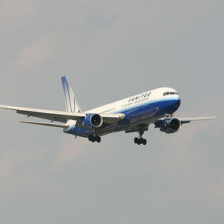
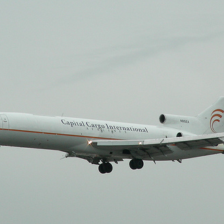
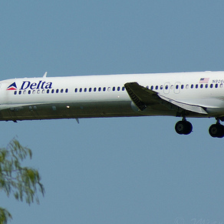
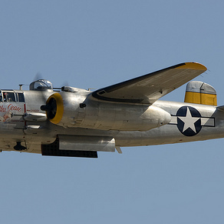
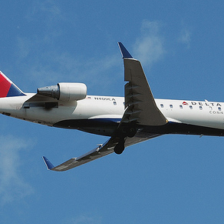
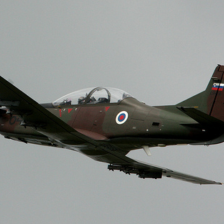
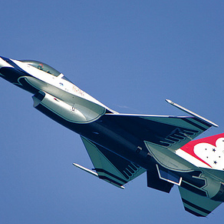

In [55]:
for i in range(1):
    print("average dot prod amongst 12 neighbors is : ", np.mean(dist[i]))
    print(dist[i])
    show_idx([indices[i]]+list(neighbor[i]))

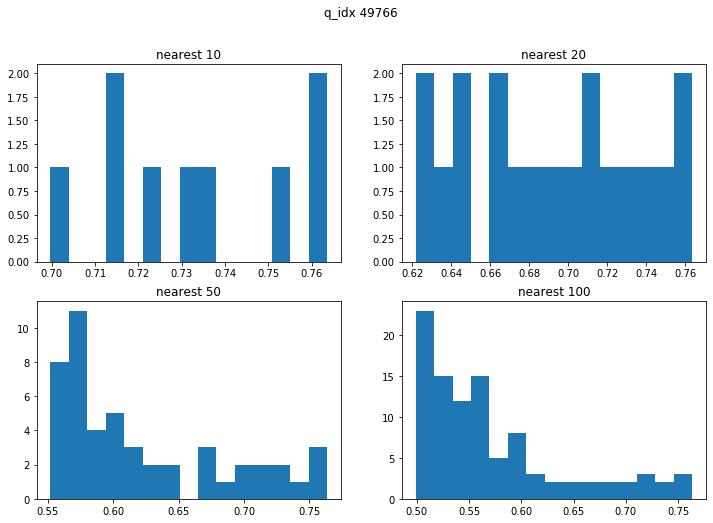

In [84]:
distance_distribution_for_id(49766, dval_feat, val_dataset)

### The top neighbors have highest similarity

In [67]:
indices, neighbor, dist = indices_with_extreme_neighbors(dval_feat, val_dataset, f=lambda x:x>0.77, n=4, howmany=1)

average dot prod amongst 12 neighbors is :  0.7716908
[0.7949436  0.7762635  0.74386525]
idx list [8719, 19051, 8603, 10697]



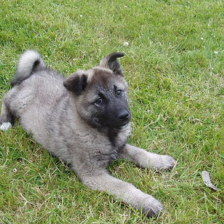
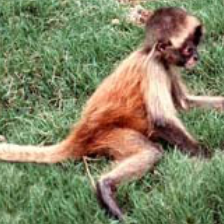
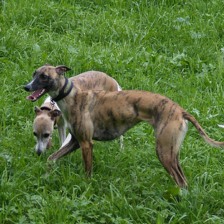
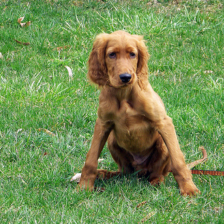

In [68]:
for i in range(1):
    print("average dot prod amongst 12 neighbors is : ", np.mean(dist[i]))
    print(dist[i])
    show_idx([indices[i]]+list(neighbor[i]))

## What are the images that have least similar images?

### Many neighbors with generally low similarity

average dot prod amongst 12 neighbors is :  0.38609636
[0.413018   0.39924526 0.39137876 0.3871471  0.38524294 0.38364148
 0.38171    0.37918854 0.377445   0.37542573 0.37361717]
idx list [42581, 43985, 34165, 39402, 30410, 2560, 42693, 32899, 24014, 37177, 6065, 32625]



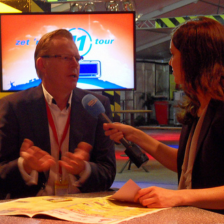
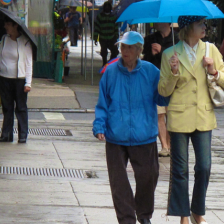
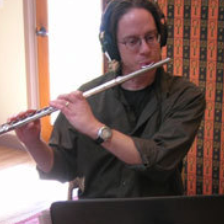
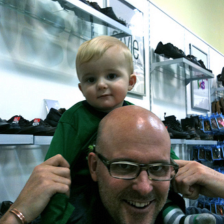
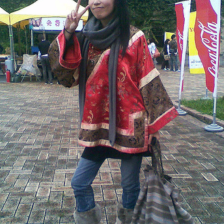
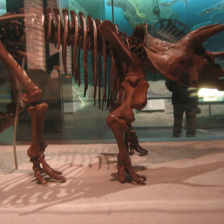
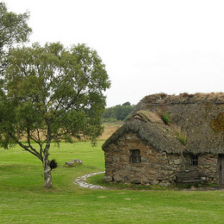
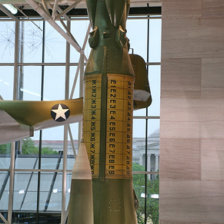
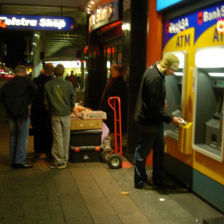
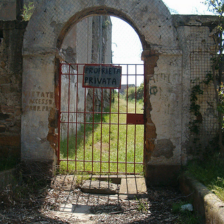
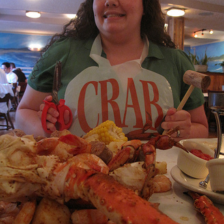
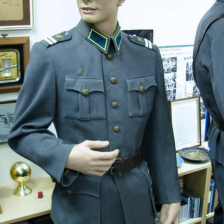

In [77]:
indices, neighbor, dist = indices_with_extreme_neighbors(dval_feat, val_dataset, f=lambda x:x<0.4, n=12, howmany=1)
for i in range(1):
    print("average dot prod amongst 12 neighbors is : ", np.mean(dist[i]))
    print(dist[i])
    show_idx([indices[i]]+list(neighbor[i]))

### Most similar images are the least similar

average dot prod amongst 12 neighbors is :  0.40118667
[0.40902865 0.39799252 0.39653885]
idx list [25325, 6156, 5724, 24091]



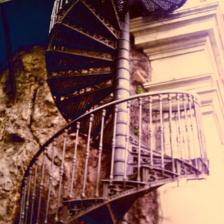
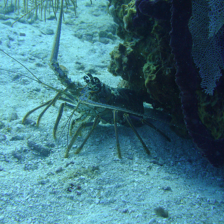
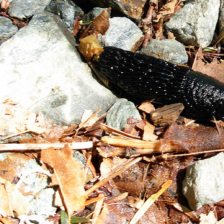
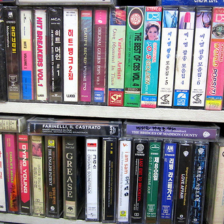

average dot prod amongst 12 neighbors is :  0.41381326
[0.4221998  0.42080206 0.39843792]
idx list [35163, 28479, 1311, 14085]



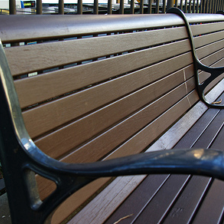
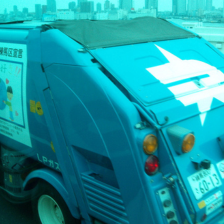
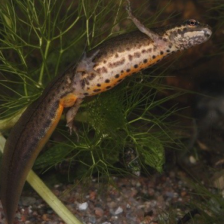
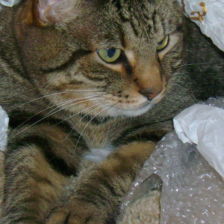

In [80]:
indices, neighbor, dist = indices_with_extreme_neighbors(dval_feat, val_dataset, f=lambda x:x<0.43, n=4, howmany=2)
for i in range(2):
    print("average dot prod amongst 12 neighbors is : ", np.mean(dist[i]))
    print(dist[i])
    show_idx([indices[i]]+list(neighbor[i]))

# Progression of Images according to epoch

Create feature dictionary by calling ``python image_to_feature.py --epochs 240 --dataset imagenet100``

In [8]:
import os

In [7]:
epochs = [_ for _ in range(160,250, 20)]
print(epochs)

[160, 180, 200, 220, 240]


In [11]:
wednesday_path = "/data/vision/torralba/scratch/yyou/wednesday/nearest_neighbors/{}".format(dataset)
pickle_path = "/data/vision/torralba/ganprojects/yyou/CMC/pkl"

In [12]:
def nearest_neighbors_at_epoch(q_id, epoch):
    epoch_name = "/ckpt_epoch_{}.pth".format(epoch)
    my_path = folder_path + model_name + epoch_name
    
    model = InsResNet50()
    print("Loading model from ... ", my_path)
    checkpoint = torch.load(my_path)
    model.load_state_dict(checkpoint['model'])
    model.cuda()
    
    path_to_feat = pickle_path + "/{}_val_to_feat_epch{}".format(dataset, epoch)
    dval_feat = load_obj(path_to_feat)
    
    nearest_idx = get_nearest_neighbor_idx(q_id, dval_feat, n=15)
    nearest_img = [split_img(val_dataset[idx][0]) for idx,score in nearest_idx]
    return nearest_img
    

In [13]:
for i in range(10):
    q_idx = random.randint(0,len(val_dataset)-1)
    print("query id : ", q_idx)
    concat_ = None
    for epoch in epochs:
        if concat_ is None:
            concat = nearest_neighbors_at_epoch(q_idx, epoch)
        else:
            concat.extend(nearest_neighbors_at_epoch(q_idx, epoch))
    imsave(concat, wednesday_path+"/progression/query_{}".format(q_idx))

query id :  992
Loading model from ...  /data/vision/torralba/ganprojects/yyou/CMC/imagenet_models/imagenet_MoCo0.999_softmax_16384_resnet50_lr_0.03_decay_0.0001_bsz_128_crop_0.2_aug_CJ/ckpt_epoch_160.pth


NameError: name 'load_obj' is not defined

In [ ]:
n=15
for i in range(10):
    q_idx = random.randint(0,len(val_dataset)-1)
    nearest_idx = get_nearest_neighbor_idx(q_idx, dval_feat, n=n)
    nearest_img = [split_img(val_dataset[idx][0]) for idx,score in nearest_idx]
    imsave(nearest_img, wednesday_path+"/epoch{}_query{}_neighbors_{}".format(epoch, q_idx, n))

In [ ]:
my_path = folder_path + model_name + epoch_name
model = InsResNet50()
model_ema = InsResNet50()
print("Loading model from ... ", my_path)
checkpoint = torch.load(my_path)
model.load_state_dict(checkpoint['model'])
model_ema.load_state_dict(checkpoint['model_ema'])
model.cuda()
model_ema.cuda()

import random

